In [1]:
import logging
logger = logging.getLogger()
for handler in logger.handlers:
    handler.level = logging.WARNING
handler = logging.FileHandler(filename='eit.log', mode='w')
handler.level = logging.INFO
logger.level = logging.INFO
logger.addHandler(handler)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sympy as sp
sp.init_printing()
import bayesian_pdes as bpdes
import matplotlib
from mcmc import pcn
%load_ext mcmc
%mcmc notebook
import scipy
from scipy import stats
import tables
import os
import bayesian_design as bd
#import gpanim
#matplotlib.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.unicode'] = True

In [3]:
bayesian_approach = True
use_real_data = False
dest_name = '/Users/benorn/samples_test_bayes_ed.h5'
seed_name = 'sim_data/truth.txt'
noise_variance = 10.0

In [4]:
class NamedLambda(object):
    def __init__(self, func, desc):
        self.__func__ = func
        self.__desc__ = desc
    def __call__(self, *args):
        return self.__func__(*args)
    def __str__(self):
        return '<NamedLambda: {}>'.format(self.__desc__)
    def __repr__(self):
        return '<NamedLambda: {}>'.format(self.__desc__)

In [5]:
seed = 124
np.random.seed(seed)

In [6]:
x_1,x_2,y_1,y_2 = sp.symbols('x_1 x_2 y_1 y_2')

In [89]:
# load in observational data
current_file = np.loadtxt('RPI_2d_chest_phantom_data/ssout1.dat')
if use_real_data:
    voltage_file = np.loadtxt('RPI_2d_chest_phantom_data/ACT2000r.txt')
    #voltage_file = np.loadtxt('RPI_2d_chest_phantom_data/ACT2006r.txt') # empty tank
else:
    voltage_file = np.loadtxt('sim_data/voltages.txt')


experiments = []
for i in range(len(current_file) / 32):
    this_currents = current_file[32*i:32*(i+1)]
    this_voltages = voltage_file[32*i+1:32*(i+1)+1]
    #this_voltages = np.random.normal(this_voltages, noise_variance)
    experiments.append((this_currents.reshape((32,1)), this_voltages.reshape((32,1))))

In [8]:
def cart2pol(points):
    x = points[:,0]
    y = points[:,1]
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return np.column_stack([rho, phi])

def pol2cart(points):
    rho = points[:,0]
    phi = points[:,1]
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return np.column_stack([x, y])

# Set Up Grid for $\kappa$

In [9]:
# there are 32 evenly spaced electrodes between 0 and 2\pi
# the electrodes go counter-clockwise from the +x axis and finish at x=1, y=0
electrodes = np.linspace(0, 2*np.pi, 33)[1:-1]
electrodes = np.append(electrodes,0)
electrode_x = np.cos(electrodes)
electrode_y = np.sin(electrodes)

bdy = np.c_[electrode_x, electrode_y]

In [10]:
def construct_shell(radii):
    r_spacing = radii[1] - radii[0]
    coords = [np.array([[0.,0.]])]
    for r in radii:
        # at each 'shell' we want a roughly equal number of theta around the diameter.
        # each theta should be about r_spacing apart
        n_theta = np.round(2*np.pi*r / r_spacing)
        thetas = np.linspace(0, 2*np.pi, n_theta+1)[:-1]
        x = np.cos(thetas)
        y = np.sin(thetas)
        coords.append(r*np.c_[x,y])
    coords = np.concatenate(coords)
    return coords

In [11]:
# we also need a few interior points
radii = np.linspace(0,1,11)[1:-1]
field_interior = construct_shell(radii)

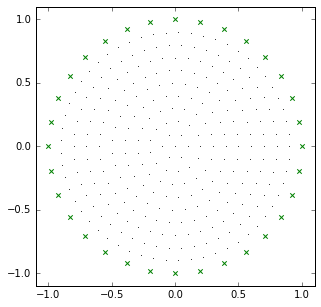

In [12]:
plt.figure(figsize=(5,5))
plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);
plt.scatter(bdy[:,0], bdy[:,1], marker='x', c='green')
plt.scatter(field_interior[:,0], field_interior[:,1], linewidth=0, c='black', s=1)

In [13]:
field_pts = np.r_[field_interior, bdy]
n_field = len(field_pts)

def vec_to_kappas(vec):
    return vec[:n_field, None], vec[n_field:2*n_field, None], vec[2*n_field:, None]

# Initial Design

In [14]:
n_pts = 40
design_radii = np.random.uniform(0,1,n_pts)
design_theta = np.random.uniform(-np.pi, np.pi, n_pts)
initial_design = pol2cart(np.column_stack([design_radii, design_theta]))

40


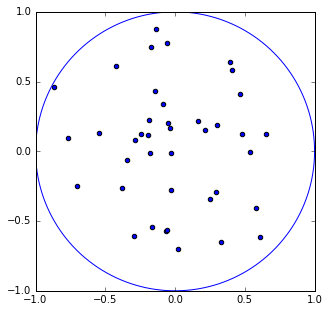

In [15]:
plt.figure(figsize=(5,5))
plt.scatter(initial_design[:,0], initial_design[:,1])
circ_r = np.ones(1000)
circ_theta = np.linspace(-np.pi, np.pi, 1000)
circ_cart = pol2cart(np.column_stack([circ_r, circ_theta]))
plt.plot(circ_cart[:,0], circ_cart[:,1])
plt.xlim([-1,1]); plt.ylim([-1,1]);
print(len(initial_design))

# Construct the Model

In [16]:
length_scale = sp.Symbol('sigma')
k_sqexp = sp.exp(-((x_1-y_1)**2 + (x_2-y_2)**2) / (2*length_scale**2))

# Operators in the expanded version of the problem
A_1 = NamedLambda(lambda k: k.diff(x_1), 'A_1')
A_2 = NamedLambda(lambda k: k.diff(x_2), 'A_2')
A_3 = NamedLambda(lambda k: k.diff(x_1, x_1) + k.diff(x_2, x_2), 'A_3')
A_1_bar = NamedLambda(lambda k: k.diff(y_1), 'A_1_bar')
A_2_bar = NamedLambda(lambda k: k.diff(y_2), 'A_2_bar')
A_3_bar = NamedLambda(lambda k: k.diff(y_1, y_1) + k.diff(y_2, y_2), 'A_3_bar')

# Transformed operators
A_t = 'A_t'
A_bar_t = 'A_bar_t'

# Boundary operators
B = NamedLambda(lambda k: (k.diff(x_1)*x_1 + k.diff(x_2)*x_2), 'B')
B_bar = NamedLambda(lambda k: (k.diff(y_1)*y_1 + k.diff(y_2)*y_2), 'B_bar')

# Transformed boundary operators
B_t = 'B_t'
B_bar_t = 'B_bar_t'

ops = [A_t, B_t]
ops_bar = [A_bar_t, B_bar_t]

ops_base = [A_1, A_2, A_3, B]
ops_bar_base = [A_1_bar, A_2_bar, A_3_bar, B_bar]
op_cache_base = bpdes.operator_compilation.compile_sympy(ops_base, ops_bar_base, k_sqexp, [[x_1, x_2], [y_1, y_2], length_scale])

In [57]:
from __future__ import print_function
class TransformedOpCache(object):
    def __init__(self, op_cache, kappa_int, kappa_bdy, grad_kappa_x, grad_kappa_y, verbosity=0):
        self.__op_cache__ = op_cache
        self.__kappa_int__ = kappa_int
        self.__kappa_bdy__ = kappa_bdy
        self.__grad_kappa_x__ = grad_kappa_x
        self.__grad_kappa_y__ = grad_kappa_y
        self.__verbosity__ = verbosity
    
    def __getitem__(self, item):
        return do_transform(item, 
                            self.__op_cache__, 
                            self.__kappa_int__, 
                            self.__kappa_bdy__, 
                            self.__grad_kappa_x__, 
                            self.__grad_kappa_y__, 
                            self.__verbosity__)

def do_transform(item, op_cache, kappa_int, kappa_bdy, grad_kappa_x, grad_kappa_y, verbosity):
    def printer(*args):
        if verbosity > 0:
            print(*args)
    exp_kappa_int = np.exp(kappa_int).reshape((len(kappa_int), 1))
    exp_kappa_bdy = np.exp(kappa_bdy).reshape((len(kappa_bdy), 1))
    grad_kappa_x = grad_kappa_x.reshape((len(grad_kappa_x),1))
    grad_kappa_y = grad_kappa_y.reshape((len(grad_kappa_y),1))
    all_things = [()]
    
    printer(exp_kappa_int.shape, exp_kappa_bdy.shape, grad_kappa_x.shape, grad_kappa_y.shape)
    
    # first explode out the objects required
    for i in item:
        if i == A_t:
            all_things = sum([[a + (A_1,), a + (A_2,), a + (A_3,)] for a in all_things], [])
        elif i == A_bar_t:
            all_things = sum([[a + (A_1_bar,), a + (A_2_bar,), a + (A_3_bar,)] for a in all_things], [])
        elif i == B_t:
            all_things = [a + (B,) for a in all_things]
        elif i == B_bar_t:
            all_things = [a + (B_bar,) for a in all_things]
        else:
            all_things = [a + (i,) for a in all_things]
    printer('Mapped {} to {}'.format(item, all_things))

    def __calc_result(x,y,fun_args=None):
        if fun_args is None:
            fun_args = []
        result = 0
        for item in all_things:
            try:
                function = op_cache[item]
            except Exception as ex:
                printer('Failed to get {}'.format(item))
                raise ex
            printer('Calling function with arguments of shape {}, {}'.format(x.shape, y.shape))
            new_mat = function(x,y,fun_args)
            
            # unbarred
            if A_1 in item:
                printer('Transforming A_1')
                multiplier = np.repeat(grad_kappa_x*exp_kappa_int,y.shape[0],1)
                new_mat = multiplier * new_mat
            elif A_2 in item:
                printer('Transforming A_2')
                new_mat = np.repeat(grad_kappa_y*exp_kappa_int,y.shape[0],1) * new_mat
            elif A_3 in item:
                printer('Transforming A_3')
                new_mat = np.repeat(exp_kappa_int,y.shape[0],1) * new_mat
                
            # barred
            if A_1_bar in item:
                printer('Transforming A_1_bar')
                new_mat = np.repeat(grad_kappa_x.T*exp_kappa_int.T,x.shape[0],0) * new_mat
            elif A_2_bar in item:
                printer('Transforming A_2_bar')
                new_mat = np.repeat(grad_kappa_y.T*exp_kappa_int.T,x.shape[0],0) * new_mat
            elif A_3_bar in item:
                printer('Transforming A_3_bar')
                new_mat = np.repeat(exp_kappa_int.T,x.shape[0],0) * new_mat
                
            # boundary
            if B in item:
                printer('Transforming B')
                new_mat = np.repeat(exp_kappa_bdy, y.shape[0], 1) * new_mat
            if B_bar in item:
                printer('Transforming B_bar')
                new_mat = np.repeat(exp_kappa_bdy.T, x.shape[0], 0) * new_mat
            result += new_mat
        return result
    return __calc_result

In [52]:
def test_function(k, sigma, sigma_bar):
    exp_sigma = sp.exp(sigma)
    exp_sigma_bar = sp.exp(sigma_bar)
    A = lambda k: (exp_sigma*k.diff(x_1)).diff(x_1) + (exp_sigma*k.diff(x_2)).diff(x_2)  
    A_bar = lambda k: (exp_sigma_bar*k.diff(y_1)).diff(y_1) + (exp_sigma_bar*k.diff(y_2)).diff(y_2)
    B = lambda k: exp_sigma*(k.diff(x_1)*x_1 + k.diff(x_2)*x_2)
    B_bar = lambda k: exp_sigma_bar*(k.diff(y_1)*y_1 + k.diff(y_2)*y_2)
    ops = [A,B]
    ops_bar = [A_bar, B_bar]
    oc = bpdes.operator_compilation.compile_sympy(ops, ops_bar, k, [[x_1, x_2], [y_1, y_2], [length_scale]], mode='f2py')
    return ops, ops_bar, oc

In [132]:
def compare_mats(sigma_fact):
    sigma = sigma_fact(x_1, x_2)
    sigma_bar = sigma_fact(y_1, y_2)
    
    kappa_int = np.vectorize(sp.lambdify([x_1, x_2], sigma))(initial_design[:,0], initial_design[:,1])
    kappa_bdy = np.vectorize(sp.lambdify([x_1, x_2], sigma))(bdy[:,0], bdy[:,1])
    kappa_x = np.vectorize(sp.lambdify([x_1, x_2], sigma.diff(x_1)))(initial_design[:,0], initial_design[:,1])
    kappa_y = np.vectorize(sp.lambdify([x_1, x_2], sigma.diff(x_2)))(initial_design[:,0], initial_design[:,1])
    
    my_oc = TransformedOpCache(op_cache_base, kappa_int, kappa_bdy, kappa_x, kappa_y)
    
    ops_test, ops_bar_test, oc_test = test_function(k_sqexp, sigma, sigma_bar)
    
    int_mat = my_oc[(A_t, A_bar_t)](initial_design, initial_design, np.array([0.2]))
    test_int_mat = oc_test[(ops_test[0], ops_bar_test[0])](initial_design, initial_design, np.array([0.2]))
    np.testing.assert_allclose(int_mat, test_int_mat)
    
    int_mat = my_oc[(A_t, B_bar_t)](initial_design, bdy, np.array([0.2]))
    test_int_mat = oc_test[(ops_test[0], ops_bar_test[1])](initial_design, bdy, np.array([0.2]))
    np.testing.assert_allclose(int_mat, test_int_mat)
    
    int_mat = my_oc[(B_t, A_bar_t)](bdy, initial_design, np.array([0.2]))
    test_int_mat = oc_test[(ops_test[1], ops_bar_test[0])](bdy, initial_design, np.array([0.2]))
    np.testing.assert_allclose(int_mat, test_int_mat)
    
    int_mat = my_oc[(B_t, B_bar_t)](bdy, bdy, np.array([0.2]))
    test_int_mat = oc_test[(ops_test[1], ops_bar_test[1])](bdy, bdy, np.array([0.2]))
    np.testing.assert_allclose(int_mat, test_int_mat)

In [131]:
compare_mats(lambda x, y: (x+y)**2)
compare_mats(lambda x, y: sp.cos(2*sp.pi*x)*sp.cos(2*sp.pi*y))

17125.3959109 17125.3959109
2423.2717016 2423.2717016


In [39]:
def plot_conductivity(thetas):
    sig_expr = get_c(x_1, x_2).subs({t: v for t,v in zip(ts, thetas)})
    sigma_field = sp.lambdify([x_1, x_2], sig_expr)
    res = np.vectorize(sigma_field)(test_x, test_y)
    plot_circle(test_x, test_y, res)
    
def plot_circle(x, y, values):
    plt.figure(figsize=(8,8))
    plt.tripcolor(x.ravel(), y.ravel(), values.ravel())
    #colors = plt.contourf(test_x, test_y, mu_shaped,  250)
    plt.colorbar()
    plt.scatter(interior[:,0], interior[:,1],  marker='x', c='black', s=50, label='Interior Points')
    plt.legend()
    plt.axis('scaled')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);
    plt.gcf().patch.set_alpha(0.0)

In [40]:
# now need to construct the thingy we are proposing over.
# Put a basis function at each point in the domain and iterate over them

# jointly proposing over the function and its derivatives wrt x and y.
# ironically constructing this is very similar to constructing our kernel matrix
Identity = lambda k: k
d1 = lambda k: k.diff(x_1)
d2 = lambda k: k.diff(x_2)
d1_bar = lambda k: k.diff(y_1)
d2_bar = lambda k: k.diff(y_2)

proposal_op_cache = bpdes.operator_compilation.compile_sympy([Identity, d1, d2], 
                                                             [Identity, d1_bar, d2_bar], 
                                                             k_sqexp, 
                                                             [[x_1, x_2], [y_1, y_2], [length_scale]]
                                                            )


In [90]:
# is there a units issue with normalising voltage here?
true_x = bdy
if seed_name is not None:
    ext = os.path.splitext(seed_name)[1]
    if ext == '.h5':
        with tables.open_file(seed_name) as tab:
            tmp = tab.get_node('/samples')
            kappa_0 = tmp[-1, :]
    elif ext == '.txt':
        tmp = np.loadtxt(seed_name)
        kappa_0 = tmp[:,2]
else:
    kappa_0 = np.zeros((n_field*3, 1))
    
currents = [e[0] for e in experiments]
voltages = [e[1] for e in experiments]
#volt_mean = np.asarray(voltages).mean()
#volt_std = np.asarray(voltages).std()
volt_mean = 0.
volt_std = 1.

In [126]:
class EITState(object):
    def __init__(self, initial_design, length_scale, regress_op_cache, debug=False):
        self.design = initial_design
        self.length_scale = length_scale
        self.regress_op_cache = regress_op_cache
        
        regress_kern = self.regress_op_cache[()]
        regress_mat = regress_kern(field_pts, field_pts, self.length_scale)
        self.inv_regress_mat = np.linalg.inv(regress_mat)
        
        self.interior_dot_mat = self.calc_interior_dot_mat(initial_design)
        self.boundary_dot_mat = self.calc_bdy_dot_mat()
        self.caching_op_cache = bpdes.operator_compilation.CachingOpCache(op_cache_base)
        
        self.debug = debug
    
    def calc_interior_dot_mat(self, design):
        regress_kern = self.regress_op_cache[()]
        left_multiplier = regress_kern(design, field_pts, self.length_scale)
        return np.dot(left_multiplier, self.inv_regress_mat)
    
    def calc_bdy_dot_mat(self):
        regress_kern = self.regress_op_cache[()]
        left_multiplier = regress_kern(bdy, field_pts, self.length_scale)
        return np.dot(left_multiplier, self.inv_regress_mat)
        
    def potential(self, proposal):
        # potential is the negative log-likelihood
        return -self.log_likelihood(proposal)
    
    def refresh_design(self, proposal, n_iter=10, n_per_iter=1):
        def get_cov_polar(points):
            cart_points = pol2cart(points)
            _, cov = self.get_posterior(proposal, cart_points, use_cache=False)
            return cov
        def pseudo_deletion(points, loss):
            cart_points = pol2cart(points)
            _, cov = self.get_posterior(proposal, cart_points, use_cache=False)
            return np.diag(cov)
        
        cur_design_polar = cart2pol(self.design)
        
        get_optimizer_bounds = lambda p: [(0., 1.), (-np.pi, np.pi)]
        
        # todo: need to couch the problem in polar coordinates so that we can just work in a square instead of a
        # circle. In a circle the optimizer will struggle.
        optimizer = bd.optimizers.gpyopt_optimizer(get_optimizer_bounds)
        
        loss = bd.a_optimality(get_cov_polar)
        new_design = bd.ace(cur_design_polar, 
                            n_per_iter, 
                            n_iter, 
                            loss, 
                            optimizer, 
                            1, 
                            deletion_function=pseudo_deletion)
        
        # update relevant fields
        self.design = pol2cart(new_design)
        self.interior_dot_mat = self.calc_interior_dot_mat(new_design)
        self.caching_op_cache.clear()
        
    def get_posterior(self, proposal, interior_points=None, use_cache=True):
        sim_kappa, sim_kappa_x, sim_kappa_y = vec_to_kappas(proposal)
        
        # use current design if interior points are none
        if interior_points is None:
            interior_dot_mat = self.interior_dot_mat
            interior_points = self.design
        else:
            interior_dot_mat = self.calc_interior_dot_mat(interior_points)
        kappa_int = interior_dot_mat.dot(sim_kappa).ravel()
        kappa_bdy = self.boundary_dot_mat.dot(sim_kappa).ravel()
        kappa_x = interior_dot_mat.dot(sim_kappa_x).ravel()
        kappa_y = interior_dot_mat.dot(sim_kappa_y).ravel()
        
        # these should all be satisfied if the interior design matches the simulation field
        #np.testing.assert_almost_equal(kappa_int, sim_kappa[:len(field_interior), 0])
        #np.testing.assert_almost_equal(kappa_bdy, sim_kappa[len(field_interior):, 0])
        #np.testing.assert_almost_equal(kappa_x, sim_kappa_x[:len(field_interior), 0])
        #np.testing.assert_almost_equal(kappa_y, sim_kappa_y[:len(field_interior), 0])

        base = self.caching_op_cache if use_cache else op_cache_base
        oc = TransformedOpCache(base, kappa_int, kappa_bdy, kappa_x, kappa_y, 0)
        
        # always observing the same boundary points
        obs = [(interior_points, None), (bdy, None)]

        posterior = bpdes.collocate(ops, ops_bar, None, None, obs, oc, fun_args=self.length_scale)
        mu_mult, cov = posterior.no_obs_posterior(true_x)
        return mu_mult, cov
    
    def log_likelihood(self, proposal):
        mu_mult, cov = self.get_posterior(proposal)
        cov_with_error = cov + noise_variance**2*np.eye(cov.shape[0])

        if bayesian_approach:
            like_dist = stats.multivariate_normal(np.zeros(cov.shape[0]), cov_with_error, False)

        ret = 0
        interior_obs = np.zeros((self.design.shape[0], 1))
        try:
            for c, v in zip(currents, voltages):
                g = np.concatenate([interior_obs, c])
                true_u = v.reshape((len(v), 1))
                mu = mu_mult.dot(g).reshape(true_u.shape)
                #print(true_u - mu)

                # todo: some inefficiency here - inverting cov multiple times
                if bayesian_approach:
                    this_lik = like_dist.logpdf(true_u.ravel() - mu.ravel())
                else:
                    this_lik = -(mu - true_u).T.dot(mu - true_u) / (2*noise_variance**2)
                ret += this_lik
        except Exception as ex:
            if self.debug:
                print(ex)
            return -np.inf
        return ret

# Experiment Design

In [127]:
ls_ml = np.array([0.1])
propose_ls = np.array([0.1])

In [128]:
state_1 = EITState(field_interior, ls_ml, proposal_op_cache, debug=False)

In [129]:
state_1.log_likelihood(kappa_0)

# MCMC

In [26]:
#tmp = scipy.optimize.minimize(np.vectorize(lambda x: potential(kappa_0, x)), 0.2, method='Nelder-Mead')
#ls_ml = tmp.x
#print(ls_ml)

In [43]:
proposal_obs = [
    (field_pts, None),
    (field_pts, None),
    (field_pts, None),
]
proposal_caching_op_cache = bpdes.operator_compilation.CachingOpCache(proposal_op_cache)
kern_mat = bpdes.collocation.calc_LLbar([Identity, d1, d2], 
                                        [Identity, d1_bar, d2_bar], 
                                        proposal_obs, 
                                        proposal_op_cache, 
                                        fun_args=propose_ls
                                       )

In [45]:
mcmc_state = EITState(initial_design, ls_ml, proposal_op_cache)

In [46]:
%%time
mcmc_state.refresh_design(kappa_0, 5)

TypeError: Argument 'extra' has incorrect type (expected numpy.ndarray, got list)

In [127]:
%load_ext line_profiler
%lprun -f bd.ace mcmc_state.refresh_design(kappa_0, 1)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


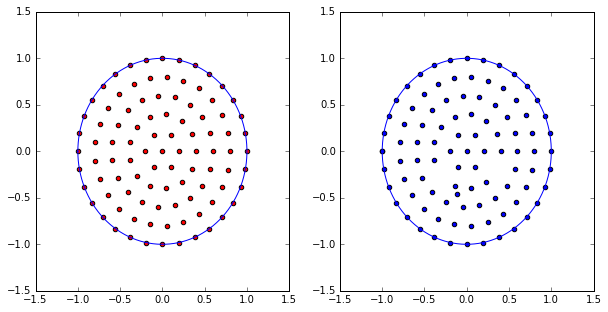

In [131]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(design_cart[:,0], design_cart[:,1], c='r')
plt.plot(circ_cart[:,0], circ_cart[:,1])
plt.subplot(122)
plt.scatter(mcmc_state.design[:,0], mcmc_state.design[:,1])
plt.plot(circ_cart[:,0], circ_cart[:,1])

In [135]:
args = np.argwhere(~np.isclose(design_cart[:,0], mcmc_state.design[:,0]) & ~np.isclose(design_cart[:,1], mcmc_state.design[:,1]))

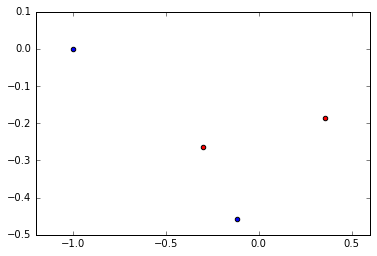

In [136]:
old = np.squeeze(design_cart[args, :])
new = np.squeeze(mcmc_state.design[args, :])
plt.scatter(new[:,0], new[:,1])
plt.scatter(old[:,0], old[:,1], c='r')

In [67]:
design_cart[:,0]

array([ -4.21579794e-01,  -3.09796058e-01,  -1.24622501e-01,
         1.71585555e-01,   1.27751567e-01,  -4.22163661e-01,
        -3.38081467e-02,  -3.23690901e-01,  -5.33539702e-02,
         6.24379470e-01,   3.00210916e-01,  -2.27643287e-01,
        -1.10743486e-01,   3.48487169e-01,   5.36132234e-01,
         1.59341042e-02,   1.27475652e-01,   5.42505633e-01,
         5.62755466e-01,   1.55091601e-01,   1.92884039e-01,
         9.42376775e-03,   5.14293914e-01,   6.39800235e-01,
         1.73102659e-01,   7.14646398e-01,   1.29312029e-01,
        -2.56576353e-01,   2.32376550e-01,  -6.02730172e-01,
         2.22776512e-01,   3.76906636e-01,   7.74835746e-01,
        -8.39940077e-05,  -3.59232259e-01,  -2.13601219e-02,
         2.07717674e-01,  -3.73670504e-01,   2.58731560e-01,
         5.18986693e-01,   3.10137705e-01,   5.28209315e-01,
         4.37519169e-01,  -7.97485696e-01,  -1.91778485e-01,
         3.36182129e-01,  -5.84856270e-02,   4.53349168e-02,
         1.36109011e-01,

In [27]:
n_iter = 500000
storage_dump_interval = int(1e3)
beta = 2.5e-6
proposal = pcn.proposal(beta, kern_mat)

In [28]:
from mcmc import storage
with storage.DiskBackedStorage((storage_dump_interval, n_field*3), dest_name) as st:
    
    _, acceptances = pcn.pCN(n_iter, proposal, mcmc_state.potential, kappa_0, storage=st)

import tables
with tables.open_file(dest_name, 'a') as tab:
    tab.create_group('/', 'params')
    tab.create_array('/params', 'beta', obj=beta)
    tab.create_array('/params', 'length_scale', obj=ls_ml)
    tab.create_array('/params', 'proposal_matrix', obj=kern_mat)
    tab.create_array('/params', 'locations', obj=field_pts)
    tab.create_array('/', 'acceptances', acceptances)

/Users/benorn/.virtualenvs/stats/lib/python2.7/site-packages/autograd/numpy/numpy_wrapper.py:54: UserWarning: r_ is slow for array inputs. np.concatenate() is faster.
  "np.concatenate() is faster.".format(slow_op_name))
/Users/benorn/.virtualenvs/stats/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/benorn/.virtualenvs/stats/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [29]:
import tables
with tables.open_file(dest_name) as tab:
    tmp = tab.get_node('/samples')
    thinned_burned = tmp[::10]

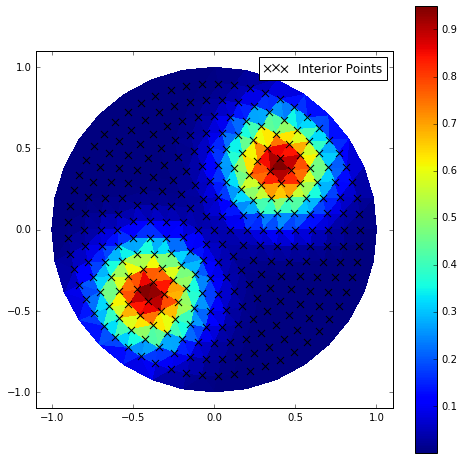

In [30]:
actual = np.mean(thinned_burned, axis=0)

plot_circle(field_pts[:,0], field_pts[:,1], np.exp(actual[:len(field_pts)]))

# Dummy diffusivity field

In [30]:
ls_ml = np.array([0.2])

In [31]:
true_kappa = sp.exp(-((x_1 - 0.4)**2 + (x_2 - 0.4)**2) / (2*0.2**2)) + sp.exp(-((x_1 + 0.4)**2 + (x_2 + 0.4)**2) / (2*0.2**2))
true_kappa_dx1 = true_kappa.diff(x_1)
true_kappa_dx2 = true_kappa.diff(x_2)

true_kappa_fun = np.vectorize(sp.lambdify([x_1, x_2], true_kappa))
true_kappa_dx1_fun = np.vectorize(sp.lambdify([x_1, x_2], true_kappa_dx1))
true_kappa_dx2_fun = np.vectorize(sp.lambdify([x_1, x_2], true_kappa_dx2))

In [32]:
true_k = np.log(true_kappa_fun(field_pts[:,0], field_pts[:,1]))
true_k_x = true_kappa_dx1_fun(field_pts[:,0], field_pts[:,1])
true_k_y = true_kappa_dx2_fun(field_pts[:,0], field_pts[:,1])
true_fun = np.r_[true_k, true_k_x, true_k_y]

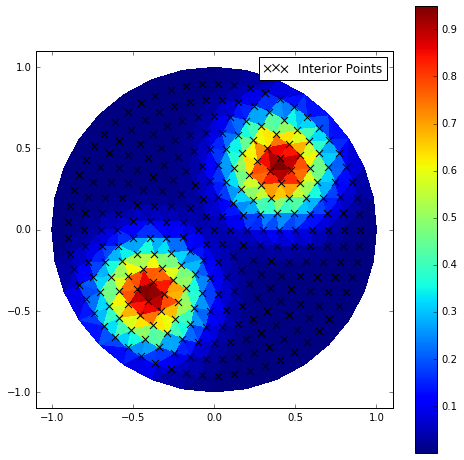

In [33]:
plot_circle(field_pts[:,0], field_pts[:,1], np.exp(true_k))

In [34]:
true_currents = [e[0] for e in experiments]
true_voltages = []
oc = TransformedOpCache(op_cache_base, true_k, true_k_x, true_k_y)
posterior = bpdes.collocate(ops, ops_bar, None, None, obs, oc, fun_args=[ls_ml])
mu_mult, cov = posterior.no_obs_posterior(true_x)
for c in true_currents:
    g = np.concatenate([interior_obs, c])
    mu = mu_mult.dot(g)
    true_voltages.append(mu)

In [35]:
voltage_file = np.concatenate([np.array([[0]])] + true_voltages)
np.savetxt('sim_data/voltages.txt', voltage_file)
np.savetxt('sim_data/truth.txt', np.c_[np.repeat(field_pts, 3, 0), true_fun[:,None]])